In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import xgboost

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [2]:
df = pd.read_csv('../Internship/data/heart.csv')

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.shape

(303, 14)

In [4]:
df['thal'].value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

In [5]:
rowstodrop = df[df['thal']==0]
df.drop(index=[48,281],axis=0,inplace=True)

In [6]:
df['thal'].value_counts()

2    166
3    117
1     18
Name: thal, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    int64  
 2   cp        301 non-null    int64  
 3   trestbps  301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    int64  
 6   restecg   301 non-null    int64  
 7   thalach   301 non-null    int64  
 8   exang     301 non-null    int64  
 9   oldpeak   301 non-null    float64
 10  slope     301 non-null    int64  
 11  ca        301 non-null    int64  
 12  thal      301 non-null    int64  
 13  target    301 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.3 KB


In [8]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
train_df = df.iloc[:, :-1]
y = df['target'].ravel()

train_df.shape, y.shape

((301, 13), (301,))

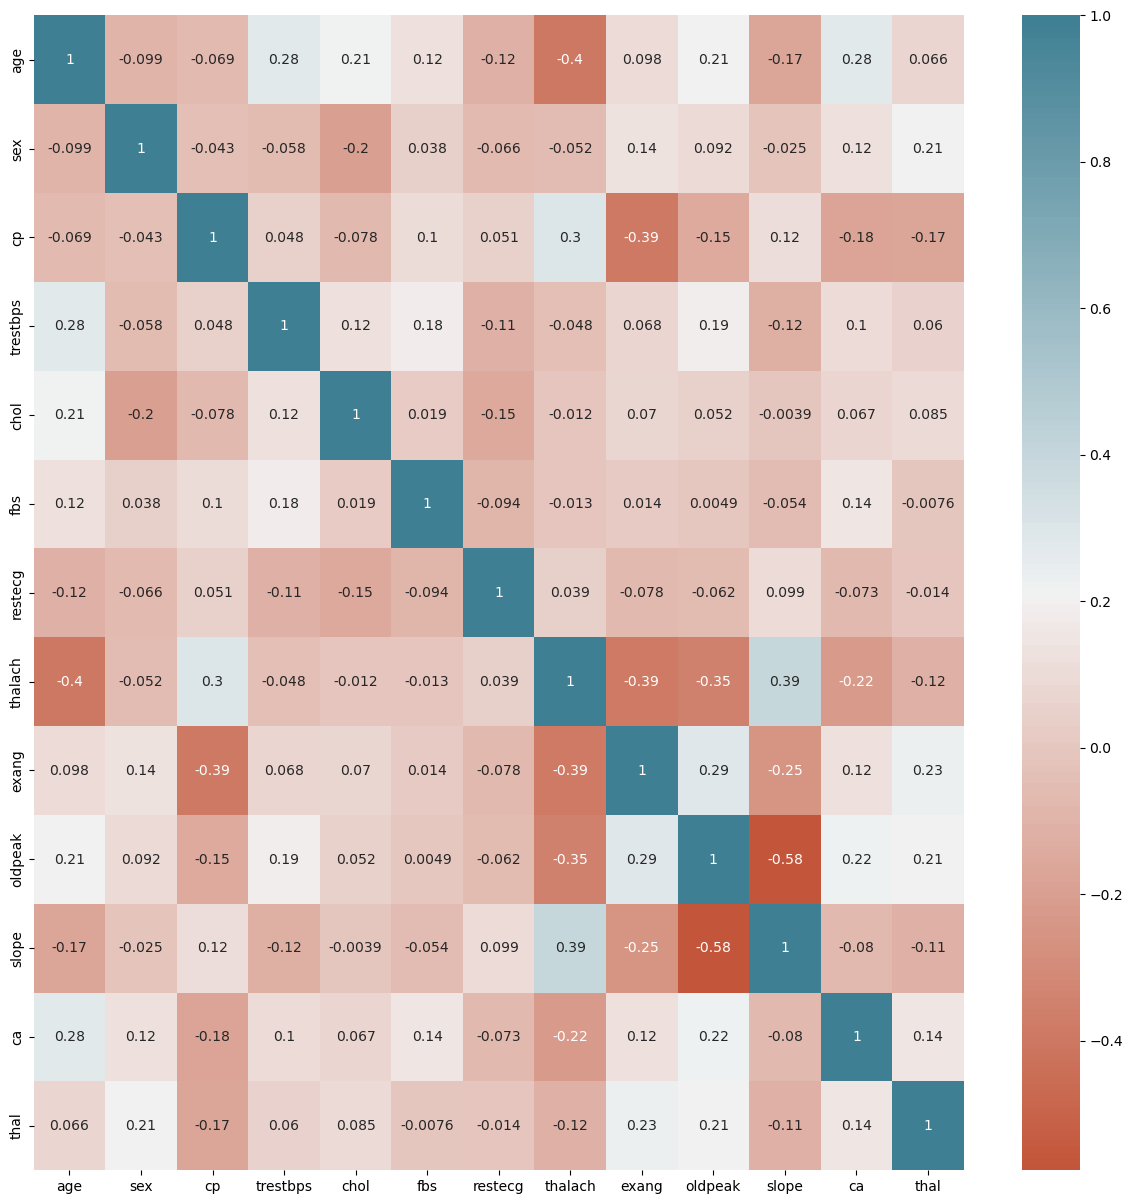

In [10]:
# correlation matrix

corr_mat = train_df.corr()
plt.figure(figsize=(15, 15))
g = sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(20, 220, n=200))

In [11]:
# find and remove correlated features

threshold = 0.8

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

correlation(train_df.iloc[:,:-1],threshold)

set()

In [12]:
# Select K best using Chi^2 test

ordered_rank_features = SelectKBest(score_func=chi2, k=13)
ordered_feature = ordered_rank_features.fit(train_df, y)

dfscores = pd.DataFrame(ordered_feature.scores_, columns=["Score"])
dfcolumns = pd.DataFrame(train_df.columns)

features_rank = pd.concat([dfcolumns, dfscores], axis=1)

features_rank.columns = ['Features','Score']

features_rank.nlargest(13, 'Score')

,Features,Score
7,thalach,194.513757
9,oldpeak,72.012196
11,ca,66.592015
2,cp,61.185148
8,exang,38.015155
4,chol,24.748493
0,age,23.540050
3,trestbps,14.946629
10,slope,9.575327
1,sex,7.245619


In [13]:
mutual_info = mutual_info_classif(train_df, y)
mutual_data = pd.Series(mutual_info, index=train_df.columns)
mutual_data.sort_values(ascending=False)

thal        0.150296
cp          0.126363
ca          0.122904
oldpeak     0.112699
exang       0.111281
chol        0.083561
thalach     0.075897
slope       0.068890
restecg     0.048578
fbs         0.032203
sex         0.013044
age         0.007956
trestbps    0.006557
dtype: float64

In [14]:
final_selected_features = ['ca', 'cp', 'exang', 'thal', 'oldpeak', 'thalach','age']

In [15]:
X = train_df[final_selected_features]

In [16]:
X.shape

(301, 7)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.15, random_state=42)

In [18]:
# using random forest classifier

rfc = RandomForestClassifier() # ravel : from (n,m) => (n,)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
# random forest classifier accuracy:
y_preds = rfc.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 82.61%


In [20]:
# using xgboost

# hyperparameter optimization

params = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7],
    "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
}

clf = xgboost.XGBClassifier()

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=5, 
    verbose=0
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc')

In [21]:
random_search.best_estimator_


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
classifier = random_search.best_estimator_

classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
# xgboost classifier accuracy:
y_preds = classifier.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 80.43%


In [24]:
score = cross_val_score(classifier, X_train, y_train, cv=10)
print(score.mean())

0.8035384615384615


In [25]:
classifier.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.3,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.0,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.15,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [26]:
# saving trained model
filename = '../Internship/models/heart_disease_model.dat'
pickle.dump(classifier, open(filename, 'wb'))

In [27]:
df.iloc[0][final_selected_features]

ca           0.0
cp           3.0
exang        0.0
thal         1.0
oldpeak      2.3
thalach    150.0
age         63.0
Name: 0, dtype: float64

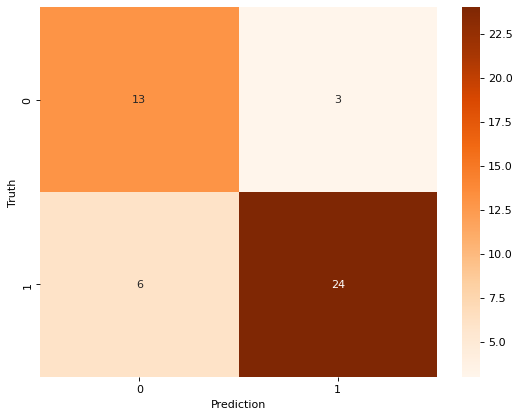

In [28]:
#Plot the confusion matrix to understand the classification in detail
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pred_ls = y_preds
test_ls = y_test
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Oranges', annot=True, fmt='d', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)